# Context

Online travel agencies (OTAs) and hotel revenue-management systems use **dynamic pricing** that reacts to lead-time, seasonality, room type, cancellations, demand, and even the day-of-week. Unlike fixed-rate package holidays, nightly prices can spike for peak weekends, local events, or when inventory (room availability) is tight. How sensitive are guests to those price swings? This project explores **price elasticity of demand** for hotel rooms, showing when higher nightly rates dampen bookings, when they’re absorbed without fuss, and what that means for revenue.

Because the raw file does not contain an explicit “demand” field, for simplicity sake, **I define demand** as the _daily count of non-cancelled bookings_ for a specific **room-type × meal-plan × day** combination. That derived metric will serve as the dependent variable throughout the analysis.   

You can find the dataset [here](https://www.kaggle.com/datasets/ahmedwaelnasef/hotel-booking).

_**In this analysis, I will be performing the following:**_

---

### Objectives

- **Estimate price elasticity of demand**:  
  Understand how changes in price affect booking volume across different room types and conditions.

- **Forecast future demand**:  
  Use time-series models (Prophet) to predict future booking trends and occupancy levels.

- **Optimise pricing strategy**:  
  Identify optimal price points that balance high revenue with stable demand.

---

**NOTE**: This project is part of my weekly series in efforts to **demystify applied statistical techniques through real-world, project-driven examples**, making concepts like propensity modelling, causal inference, and evaluation metrics more accessible to practitioners of all backgrounds.


### Let's connect! --> [LinkedIn](https://www.linkedin.com/in/einstein-ebereonwu/) | [X](https://x.com/einsteinmuna) | [GitHub.](https://github.com/munas-git)

In [1]:
# data wrangling
import calendar
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# numerical analysis
import numpy as np
import scipy.stats as stats
from collections import Counter

# wholistic outlier/anomaly detection
from sklearn.ensemble import IsolationForest

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# model training
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor)

from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# model evaluation
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, median_absolute_error, r2_score,
    explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance)

# hyper-params optimisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model explainability
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay as pdp

# counterfactual
from itertools import product

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [2]:
df = pd.read_csv('/kaggle/input/hotel-booking/Hotel.csv')
df.head()

,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,market_segment,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# Initial EDA, Feature Engineering & Table Merging.

## Initial EDA

In [3]:
df.columns

Index(['ID', 'n_adults', 'n_children', 'weekend_nights', 'week_nights',
       'meal_plan', 'car_parking_space', 'room_type', 'lead_time', 'year',
       'month', 'date', 'market_segment', 'repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'avg_room_price', 'special_requests', 'status'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              36275 non-null  object 
 1   n_adults                        36275 non-null  int64  
 2   n_children                      36275 non-null  int64  
 3   weekend_nights                  36275 non-null  int64  
 4   week_nights                     36275 non-null  int64  
 5   meal_plan                       36275 non-null  object 
 6   car_parking_space               36275 non-null  int64  
 7   room_type                       36275 non-null  object 
 8   lead_time                       36275 non-null  int64  
 9   year                            36275 non-null  int64  
 10  month                           36275 non-null  int64  
 11  date                            36275 non-null  int64  
 12  market_segment                  

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
n_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0


**Observation**   

No missing data, that's good.   

However, there are outliers... Some quite extreme like `n_children` and `week_nights`, and some others which are not so extreme. There is also no repeated data. For further understanding of the potential outliers, I will be taking a closer look using box plots.   

**Note:**  
I identified potential outliers from the describe table statistics by examining the ***mean, standard deviation, and maximum values***. *With the assumption that the data follows an approximately normal distribution*, I flagged observations as outliers if they fall beyond 3 standard deviations from the mean (99.7th percentile).

## Basic Outlier detection

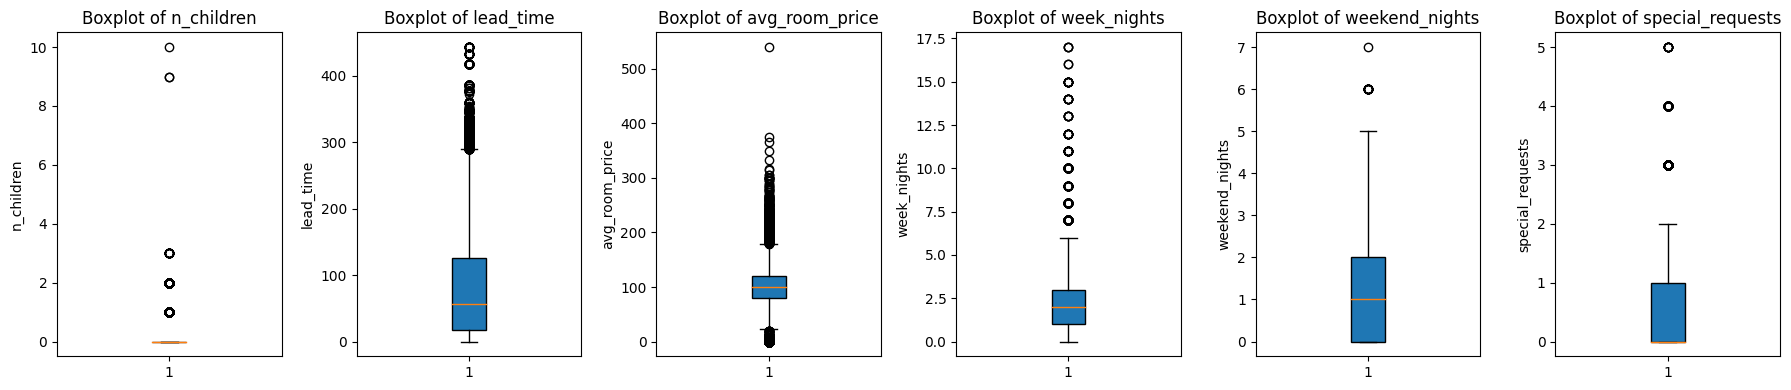

In [6]:
cols_to_plot = [
    'n_children', 'lead_time', 'avg_room_price',
    'week_nights', 'weekend_nights', 'special_requests']

plt.figure(figsize = (18, 4))

for i, col in enumerate(cols_to_plot, start = 1):
    plt.subplot(1, 6, i)
    plt.boxplot(df[col], patch_artist = True)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [7]:
print(f'Different room types: {sorted(df.room_type.unique())}')
df[df['n_children'] > 8].sort_values(by = 'n_children', ascending = False)

Different room types: ['Room_Type 1', 'Room_Type 2', 'Room_Type 3', 'Room_Type 4', 'Room_Type 5', 'Room_Type 6', 'Room_Type 7']


,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,market_segment,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status
6338,INN06339,2,10,0,2,Meal Plan 1,0,Room_Type 4,37,2018,1,12,Online,0,0,0,84.45,1,Not_Canceled
10041,INN10042,1,9,2,1,Meal Plan 1,0,Room_Type 1,11,2017,10,11,Corporate,0,0,0,95.00,0,Not_Canceled
10061,INN10062,2,9,2,5,Meal Plan 1,0,Room_Type 2,8,2017,8,13,Online,0,0,0,76.50,1,Canceled


In [8]:
original_avg_room_price_1p8_percentile = df['avg_room_price'].quantile(0.018)
print(f'Unclean dataset "avg_room_price" 1.8th percentile: {original_avg_room_price_1p8_percentile:.2f}')

Unclean dataset "avg_room_price" 1.8th percentile: 36.25


**Observations**

- **`n_children`**: Based on the boxplot, values above **8 children** clearly stand out as potential outliers. However, upon closer inspection, I noticed that:
  - The **highest value** (10 children) occurred in **Room_Type 4**, which I assume is one of the **larger room types**.
  - The booking was made around **New Year**, a time known for **gatherings or events**.
  - The guest also included a **special request**, suggesting this may have been a **group event or party**, rather than a single family booking.

**Note**  
Since the outliers identified here is quite plausible, simply dropping all **univariate outliers** wouldn't be wise, and I don't want to have to individually inspect `lead_time, average_room_price,` and the rest in the same manner, only to observe similar plausible patterns. There are very obvious issues with the `average room prices`, as quite a number of them are 0 or near it. I will handle that shortly.   

For a more robust approach to outlier identification, I'll be working with **Isolation Forests**. This technique helps identify **observation-level outliers** rather than just feature-level anomalies, a more **holistic and scalable** approach, especially useful for **production settings**.

## Initial Feature Engineering + Advanced Outlier Detection & Handling

In [9]:
# ordinal category mappings
meal_plan_mapping = {'Not Selected': -1, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3}
room_type_mapping = {'Room_Type 1': 1, 'Room_Type 2': 2, 'Room_Type 3': 3, 'Room_Type 4': 4, 
                     'Room_Type 5': 5, 'Room_Type 6': 6, 'Room_Type 7': 7}

df['meal_plan'] = df['meal_plan'].map(meal_plan_mapping)
df['room_type'] = df['room_type'].map(room_type_mapping)


# label encoding... binary
status_le = LabelEncoder()
df['status'] = status_le.fit_transform(df['status'])

# one-hot encode nominal category
ohe = OneHotEncoder(sparse_output = False, dtype = int, drop = 'first')
market_segment_encoded = ohe.fit_transform(df[['market_segment']])

feature_names = [f"market_segment_{cat}" for cat in ohe.categories_[0][1:]] # excluding first
for i, col_name in enumerate(feature_names):
    df[col_name] = market_segment_encoded[:, i]

df = df.drop('market_segment', axis = 1)

In [10]:
df.head()

,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,...,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online
0,INN00001,2,0,1,2,1,0,1,224,2017,...,0,0,0,65.00,0,1,0,0,1,0
1,INN00002,2,0,2,3,-1,0,1,5,2018,...,0,0,0,106.68,1,1,0,0,0,1
2,INN00003,1,0,2,1,1,0,1,1,2018,...,0,0,0,60.00,0,0,0,0,0,1
3,INN00004,2,0,0,2,1,0,1,211,2018,...,0,0,0,100.00,0,0,0,0,0,1
4,INN00005,2,0,1,1,-1,0,1,48,2018,...,0,0,0,94.50,0,0,0,0,0,1


In [11]:
X = df.drop(['ID'], axis = 1)

iso = IsolationForest(
    n_estimators = 300,
    contamination = 0.001,
    random_state = 42)

iso.fit(X)

df["iso_flag"]  = iso.predict(X)
df["iso_score"] = iso.decision_function(X)

outliers = (
    df[df["iso_flag"] == -1]
    .sort_values("iso_score"))

# display(outliers)

In [12]:
print(f'Outliers percentage: {round(len(df[df["iso_flag"] == -1]) / len(df) * 100, 4)}%')
print(f'Number of identified outliers: {len(df[df["iso_flag"] == -1])}')
print(f'Number of borderline observations (confusing to decice by model): {len(df[df["iso_score"] == 0])}')

Outliers percentage: 0.102%
Number of identified outliers: 37
Number of borderline observations (confusing to decice by model): 0


In [13]:
# Quick sanity check... is the January case of 10 kids and room type 4 flagged?
'INN06339' in outliers['ID'].values

False

### Further dive into what exactly makes them outliers

In [14]:
# In this cell, I use each tree to extract the decision path for each sample,
# then track which features were used to isolate each outlier.
# Features that appear earlier in the path get more weight.
# In the end, I quantify how much each feature contributed to the isolation,
# helping explain which feature combinations result in rare/anomalous observations.


# ====================== VERY IMPORTANT REUSABLE FUNCTION FOR FUTURE PROJECTS (Outlier Flag Explainability) ======================
def get_contributions(model, X, row_idx, feature_names, threshold = 0.05):
    x = X[row_idx].reshape(1, -1)
    contrib = np.zeros(X.shape[1])

    for tree in model.estimators_:
        node_ids = tree.decision_path(x).indices
        for depth, node_id in enumerate(node_ids, start = 1):
            feat = tree.tree_.feature[node_id]
            if feat >= 0:
                contrib[feat] += 1 / depth # higher weight to quicker splits... inverse or smaller numbers are higher
            else:
                break
                
    contrib /= contrib.sum()
    return pd.Series(contrib, index = feature_names, name = row_idx)
# ====================== VERY IMPORTANT REUSABLE FUNCTION FOR FUTURE PROJECTS (Outlier Flag Explainability) ======================



# outliers only
outlier_idx = df[df['iso_flag'] == -1].sort_values('iso_score').index
feature_names = X.columns

contrib_df = pd.DataFrame([
    get_contributions(iso, X.values, i, feature_names)
    for i in outlier_idx], index = outlier_idx)

value_df = X.loc[outlier_idx].copy()
value_df['iso_score'] = df.loc[outlier_idx, 'iso_score']
gmap = contrib_df.where(contrib_df > 0.05, 0.0)
gmap["iso_score"] = 0.0

styled = (value_df.style.background_gradient(cmap = 'Reds', axis = None, gmap = gmap).format('{:.4f}'))


print('NOTE: The heavier the shade of red, the more significant the feature was in determining the observation is an outlier\n')
display(styled) # .... This only works in notebook environments, so I suggest viewing the Kaggle notebook.

NOTE: The heavier the shade of red, the more significant the feature was in determining the observation is an outlier



,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,iso_score
21880,1.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,11.0000,2018.0000,12.0000,17.0000,1.0000,5.0000,57.0000,67.0000,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000,-0.0385
23366,4.0000,0.0000,0.0000,1.0000,1.0000,1.0000,7.0000,4.0000,2018.0000,5.0000,13.0000,1.0000,0.0000,2.0000,0.0000,4.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0315
8622,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,1.0000,5.0000,2018.0000,12.0000,5.0000,1.0000,2.0000,8.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0290
33393,1.0000,0.0000,0.0000,3.0000,1.0000,1.0000,4.0000,0.0000,2018.0000,1.0000,5.0000,1.0000,0.0000,12.0000,0.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0274
27665,2.0000,0.0000,1.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,12.0000,19.0000,1.0000,4.0000,20.0000,0.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0270
3050,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,5.0000,4.0000,1.0000,4.0000,15.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0246
18794,1.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,7.0000,2018.0000,12.0000,14.0000,1.0000,5.0000,56.0000,67.0000,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000,-0.0246
36080,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,3.0000,21.0000,1.0000,3.0000,15.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0228
19292,3.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,71.0000,2018.0000,10.0000,15.0000,1.0000,0.0000,32.0000,0.0000,4.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0224
35983,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,6.0000,7.0000,1.0000,4.0000,17.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0217


**Observation**

This technique was not only effective in identifying records with an `avg_room_price` of **0.0**, but it also identified other **rare booking combinations**. For example, bookings made for **1 adult to span across 2 weekend nights and 1 week night, with 2 special requests in December** is quite uncommon.... Something more common based on my own intuition would be 2 adults and at least 1 child, for that timwe of the year. Anyways, `I will be proceeding with a 2-step approach`....   

**1.** ***Dropping Outliers***   
I will be dropping every single identified outlier, since there are only 37 of them and not a significant loss compared to the amount of data I have. I will also be excluding every observation with room price above 400 after that, in order to avoid unnecessary skewing.

**2.** ***Imputing Wrong Prices***

After removing the outliers, I will be **replacing the `avg_room_price` values of 0** with predictions from a **K-Nearest Neighbors (KNN) regressor**, using booking-specific patterns across all features in order to balance **precision** with **robustness** unlike a mean fill which may have lost some finer details.

In [15]:
df_clean = df.drop(outliers.index)
print(f'Number of cleaned observations with room price above 400 --> {len(df_clean[df_clean["avg_room_price"] >= 400])}')

df_clean = df_clean[df_clean['avg_room_price'] < 400]

Number of cleaned observations with room price above 400 --> 1


In [16]:
# some clean up

cleanup_cols = ['ID', 'iso_flag', 'iso_score']
df_clean.drop(cleanup_cols, axis = 1, inplace = True)

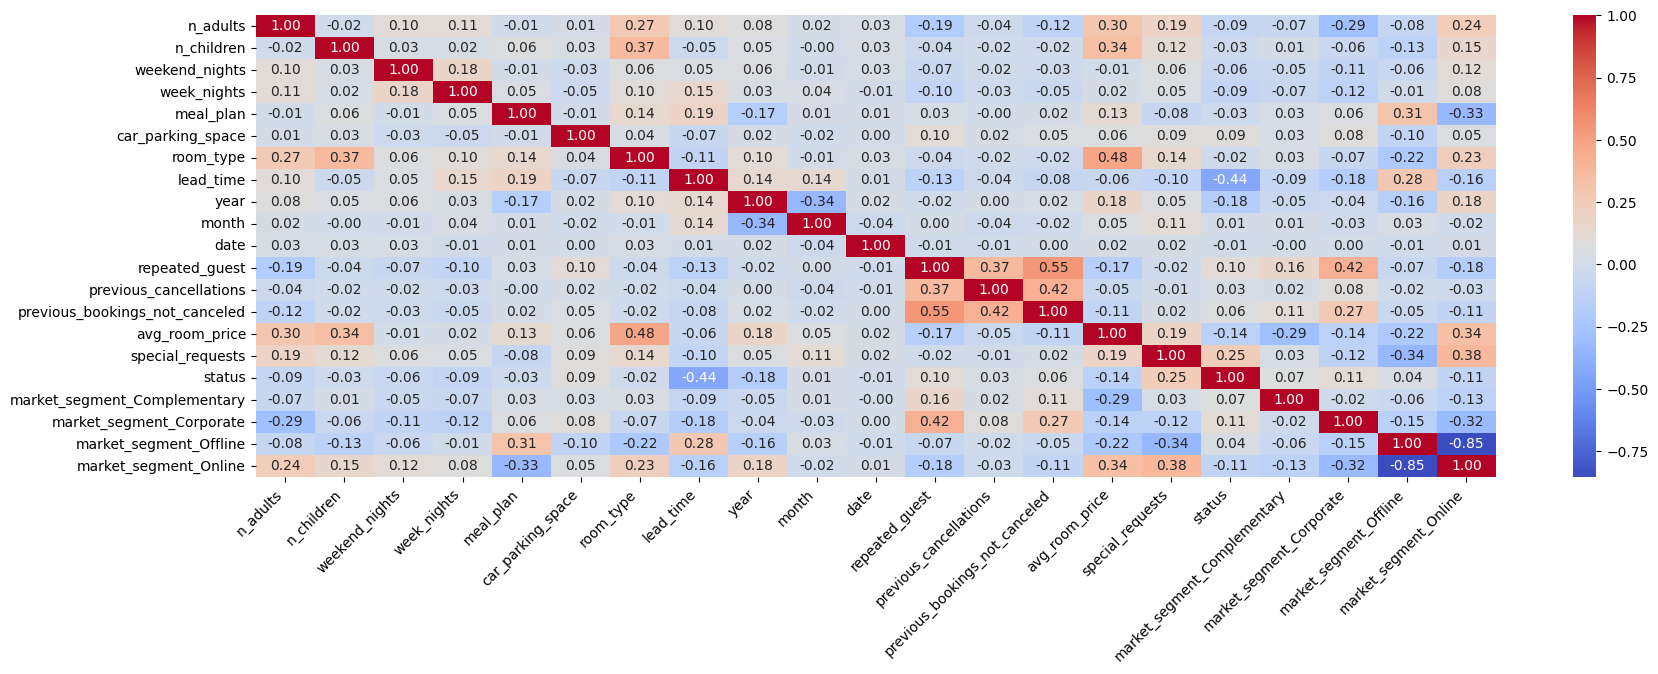

In [17]:
corr = df_clean.corr()

plt.figure(figsize = (20, 6))
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.xticks(rotation = 45, ha = 'right');

**Observation**

As expected, the one-hot-encoded variables are highly correlated, and will be ignored. Asides those, the `repeated_guest` and `previous_bookings_not_canceled` are highly correlated with a correlation score of ***0.55***. I will be dropping `repeated_guest` because any `previous_bookings_not_canceled` *> 1* automatically equates to a repeat guest and the number of prevoous bookings not cancelled carries more information than just a boolean flag.

In [18]:
# some extra clean up

cleanup_cols = ['repeated_guest']
df_clean.drop(cleanup_cols, axis = 1, inplace = True)

print(f'Number of cleaned observations with unlikely average price: {len(df_clean[df_clean["avg_room_price"] <= original_avg_room_price_1p8_percentile])}')

Number of cleaned observations with unlikely average price: 629


## KNN Data Imputation

In [19]:
train_df = df_clean[df_clean['avg_room_price'] > original_avg_room_price_1p8_percentile].copy()
pred_df  = df_clean[df_clean['avg_room_price'] <= original_avg_room_price_1p8_percentile].copy()

feature_cols = [c for c in df_clean.columns if c != 'avg_room_price']
X_train = train_df[feature_cols]
y_train = train_df['avg_room_price']
X_pred  = pred_df[feature_cols]

one_hot_cols = [c for c in feature_cols if c.startswith('market_segment_')]
ordinal_cols = [c for c in feature_cols if c not in one_hot_cols]

# ordinal feature scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_pred_scaled = X_pred.copy()

X_train_scaled[ordinal_cols] = scaler.fit_transform(X_train[ordinal_cols])
X_pred_scaled[ordinal_cols] = scaler.transform(X_pred[ordinal_cols])

# Grid search for best k
param_grid = {'n_neighbors': [3, 5, 6, 7, 9, 11]}
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

gs = GridSearchCV(KNeighborsRegressor(metric = 'euclidean'),
                  param_grid, cv=cv,
                  scoring = 'neg_mean_squared_error', n_jobs = -1)
gs.fit(X_train_scaled, y_train)

print(f'Best k: {gs.best_params_["n_neighbors"]}  (CV RMSE ~= {(-gs.best_score_) ** 0.5:0.1f})')

# filling outlier prices.
best_knn = gs.best_estimator_
pred_prices = best_knn.predict(X_pred_scaled)
df_clean.loc[df_clean['avg_room_price'] <= original_avg_room_price_1p8_percentile, 'avg_room_price'] = pred_prices

df_clean['avg_room_price'].describe()

Best k: 5  (CV RMSE ~= 18.1)


count    36237.000000
mean       105.238678
std         32.435830
min         36.380000
25%         81.000000
50%        100.000000
75%        121.000000
max        375.500000
Name: avg_room_price, dtype: float64

**Observation**

Price descriptive stats look wayyy better than before... Time to engineer the demand feature, and move on to price elasticity of demand modelling, demand forcasting and price optimisation.